# Process scRNA for label transfer
Please, save the anndata object as follows

```
# adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
# adata_count.write('data/organoids-all-TC-keep-ccg_forSeurat.h5ad')
```


In [ ]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
sessionInfo()

In [ ]:
# we know these genes are relevant, use them to keep track on how good we're doing
known_genes = c('TOP2A', 'PCNA', 'LGR6', 'KRT5',
           'SOX9', 'MMP7', 'WNT7A', 'KRT13',
           'PLAU',  'PLAUR', 'SCGB2A1', 'PAEP', 
           'SPP1', 'SCGB2A2', 'HEY1', 'SERPINA1', 
           'TP73', 'FOXJ1', 'PIFO', 'RSPH1', 'PGR')

# Process with Seurat from raw

In [5]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = 'data/organoids-confI_Donor44_forSeurat.h5ad')
allgenes = rownames(anndata)
anndata

Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
22468 features across 15869 samples within 1 assay 
Active assay: RNA (22468 features, 0 variable features)

In [6]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)

In [7]:
table(is.na(rownames(anndata)[ anndata@assays$RNA@meta.features$is.HVG ] ))


FALSE  TRUE 
 2660     6 

In [8]:
anndata = subset(anndata, features = rownames(anndata)[ anndata@assays$RNA@meta.features$is.HVG ] )
anndata <- FindVariableFeatures(anndata, nfeatures = 20000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Warning message in subset.Assay(x = x[[assay]], cells = cells, features = assay.features):
“NAs passed in the features vector, removing NAs”
Centering and scaling data matrix



In [9]:
# # check cell cycle effect
# anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
# anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
# DimPlot(anndata, reduction = 'pca')

In [10]:
# # Regress out cell cycle - NOTE: subset the dataset to speed up process
# anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  TPM4, CCND1, IGFBP2, LDHA, S100A16, KRT7, TUBB, HLA-DMB, HMGA1, TACSTD2 
	   TPM1, CTSB, PXDN, CTSC, CALD1, TPD52L1, COL4A2, ZFP36L1, BIN1, LAMC1 
	   MGST1, IER3, FGF18, STMN1, COL4A1, TSPO, HES1, HES4, LY6E, ADI1 
Negative:  FAM183A, TPPP3, C20orf85, FAM92B, C9orf135, CCDC170, DNAH12, LRRC46, C1orf194, TEKT1 
	   C11orf97, ROPN1L, ZMYND10, C11orf88, ENKUR, MORN5, EFCAB1, C5orf49, RSPH4A, SAXO2 
	   SNTN, CAPSL, EFCAB10, CFAP53, RSPH1, SMIM6, DNAAF1, TUBA4B, PPP1R42, CCDC65 
PC_ 2 
Positive:  STMN1, HMGB1, HMGN2, NUCKS1, NASP, H1FX, SRSF7, RBBP7, MDK, CBX5 
	   DEK, TUBA1B, PSIP1, STXBP6, DTYMK, BCAM, RANBP1, EMX2, TMPO, HSPE1 
	   MEIS1, SNRNP25, SPRY1, H2AFV, HMGB3, IGF2, H2AFZ, PTGES3, ITM2C, TUBB 
Negative:  ANXA2, PHLDA2, LAMA3, CD44, LAMB3, KRT19, PLAU, ITGB8, IL18, S100A10 
	   MACC1, GPRC5A, DUSP5, RAB11FIP1, C19orf33, CXCL8, PLAUR, SLC7A11, SCEL, TM4SF1 
	   LAMC2, TGM2, MYOF, ZNF185, SERPINB1, ALDH1A3, SH3BGRL3, CLDN1, EMP1, KRT8 
PC_ 3 
Positive:  H2AFZ, L

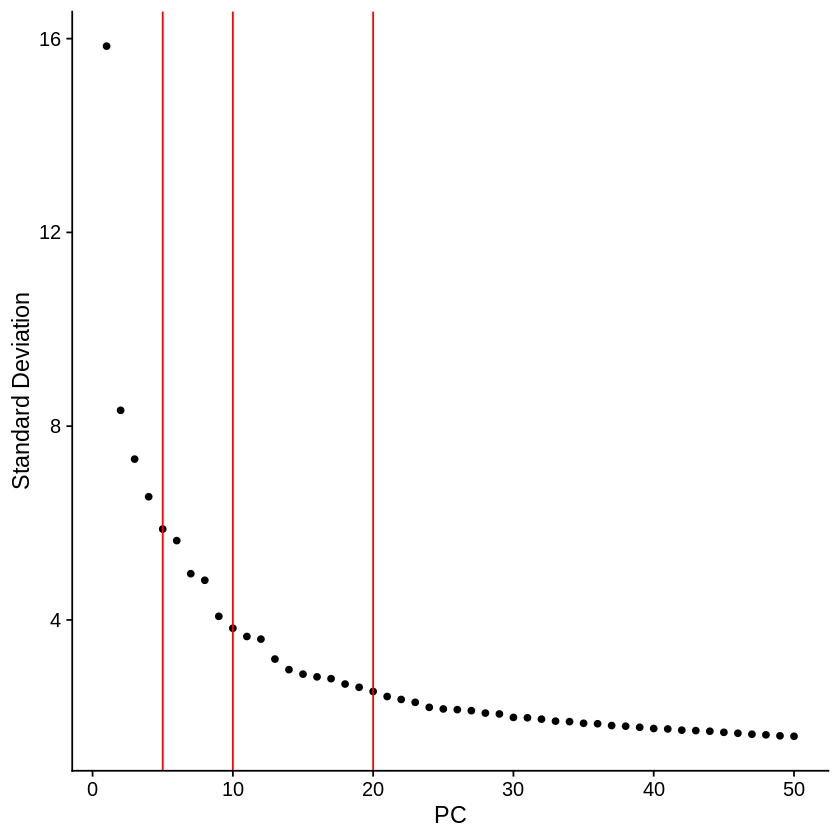

In [11]:
# # Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [12]:
npca = 12
# Correct donor's effect on PCA
# anndata <- RunHarmony(anndata, group.by.vars = 'Donor', dims.use = 1:npca, theta = 2)

In [13]:
# Cluster
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


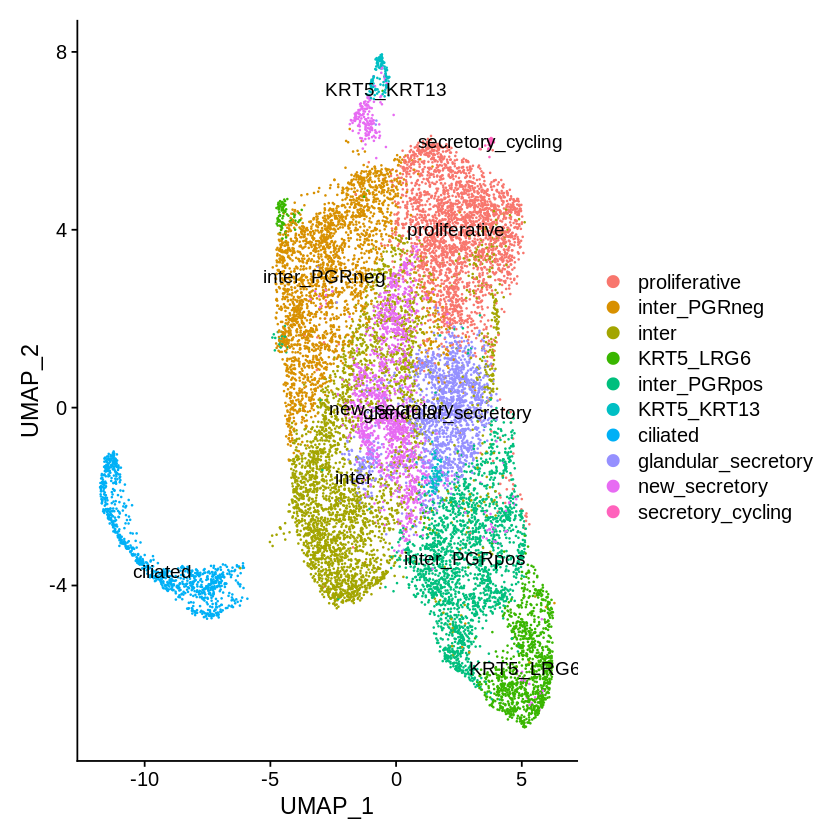

In [14]:
# Plot previous cluster
clustering = read.csv('figures_organoid_confInhibitors/Donor44/barcode_metadata.csv', stringsAsFactors = F)
rownames(clustering) = clustering$index
anndata@meta.data$clusters = clustering[rownames(anndata@meta.data), ]$clusters

# Assign identities and check
Idents(anndata) <- anndata@meta.data$clusters
DimPlot(anndata, reduction = "umap", label = T)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15869
Number of edges: 479984

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8605
Number of communities: 13
Elapsed time: 1 seconds


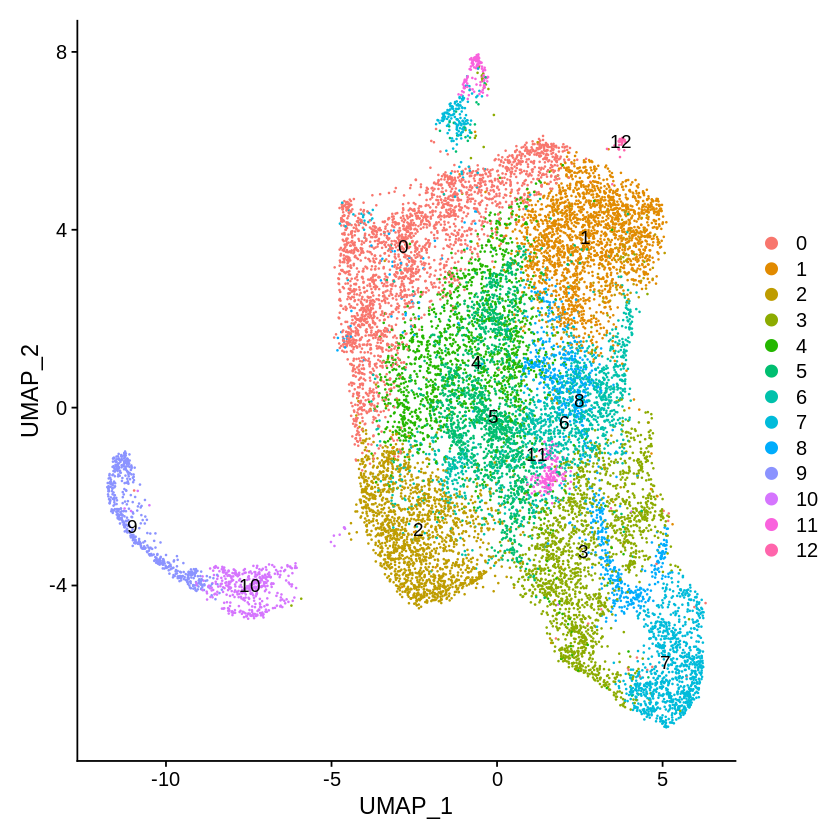

In [15]:
# Cluster de novo
anndata <- FindClusters(anndata, resolution = 0.5)
DimPlot(anndata, reduction = "umap", label = T)

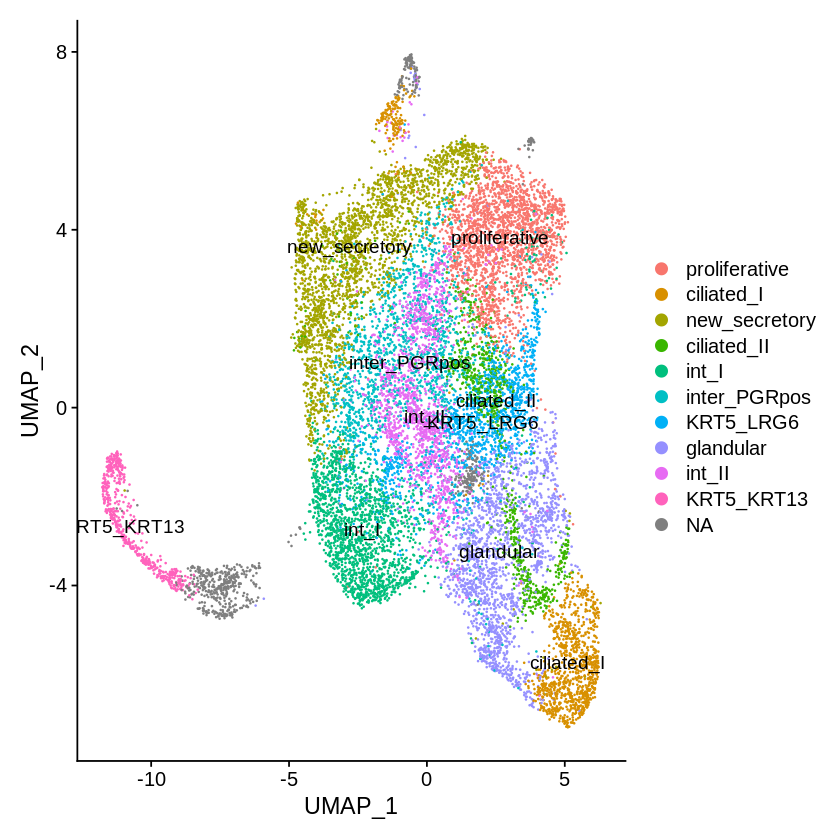

In [16]:
annotation = c('0'='new_secretory',
                  '1'='proliferative',
                  '2'='int_I',
                  '3'='glandular',
                  '4'='inter_PGRpos',
                  '5'='int_II',
                  '6'='KRT5_LRG6',
                  '7'='ciliated_I',
                  '8'='ciliated_II',
                  '9'='KRT5_KRT13'
)
Idents(anndata) <- annotation[ anndata@meta.data$seurat_clusters ]
DimPlot(anndata, reduction = "umap", label = T)

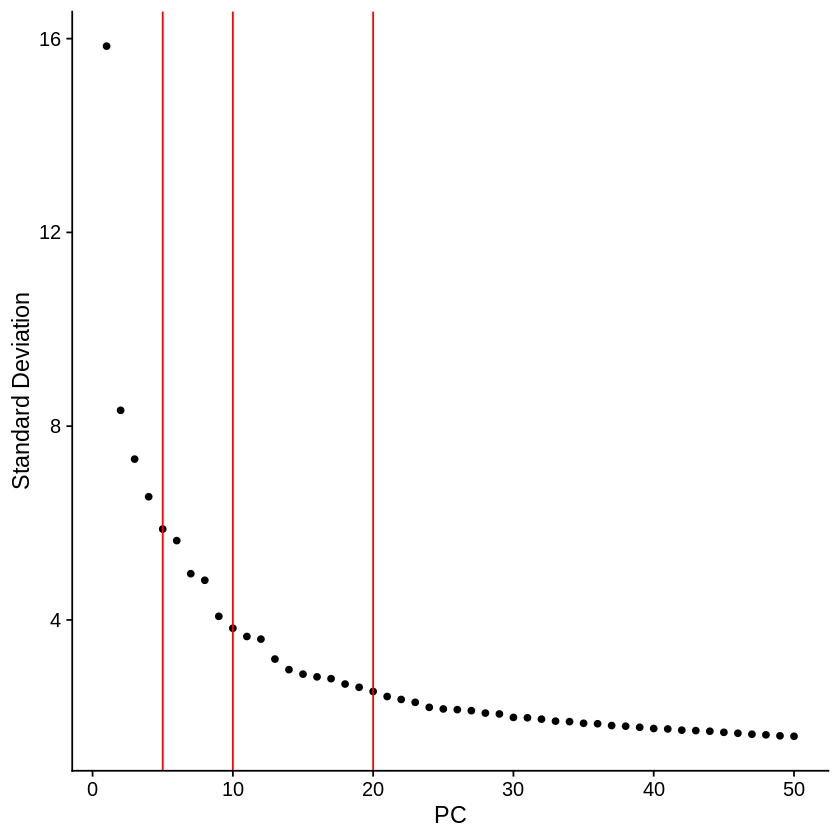

In [17]:
control_subset <- subset(anndata, ident = 'KRT5_KRT13')
DefaultAssay(control_subset) <- "RNA"
control_subset <- FindVariableFeatures(control_subset, selection.method = "vst", nfeatures = 3000)
control_subset <- ScaleData(control_subset, verbose = FALSE)
control_subset <- RunPCA(control_subset, npcs = 30, verbose = FALSE)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: LGR6”


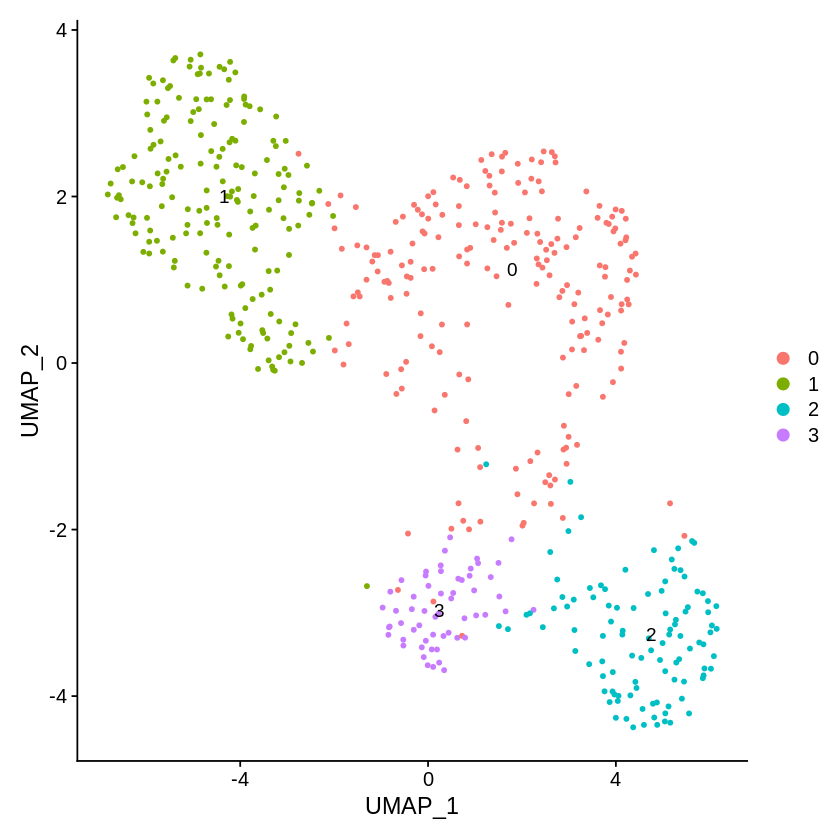

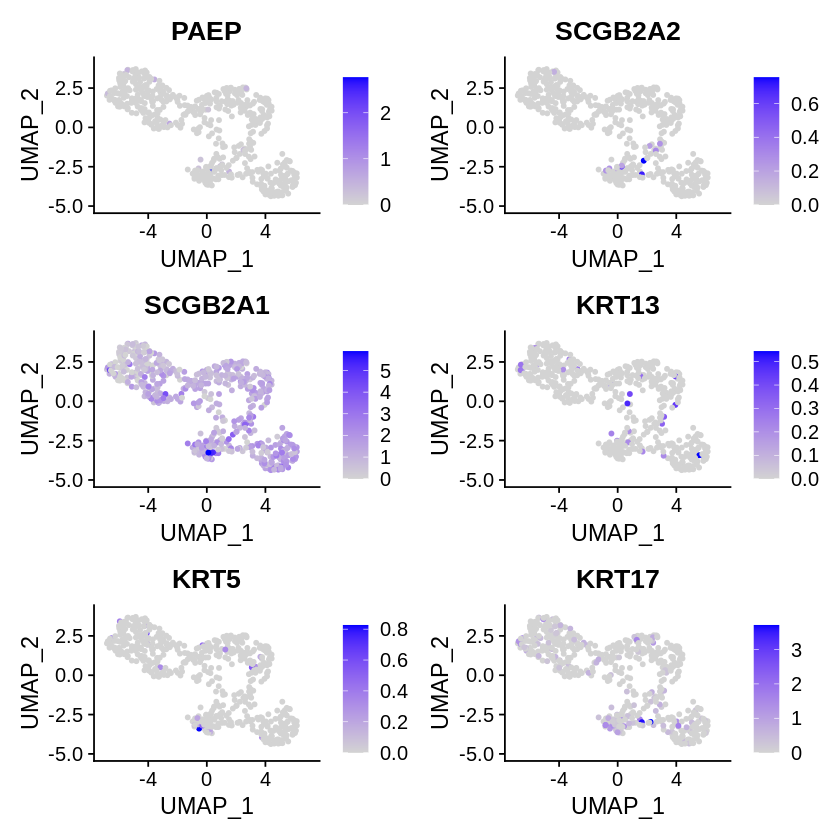

In [18]:
control_subset <- FindNeighbors(control_subset, dims = 1:7, verbose = FALSE)
control_subset <- RunUMAP(control_subset, dims = 1:7, verbose = FALSE)
control_subset <- FindClusters(control_subset, resolution = 0.2, verbose = FALSE)
DimPlot(control_subset, reduction = "umap", label = T)
FeaturePlot(control_subset, features = c('PAEP','SCGB2A2','SCGB2A1','KRT13', 'KRT5', 'LGR6', 'KRT17'))

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: TOP2A, PCNA, LGR6”


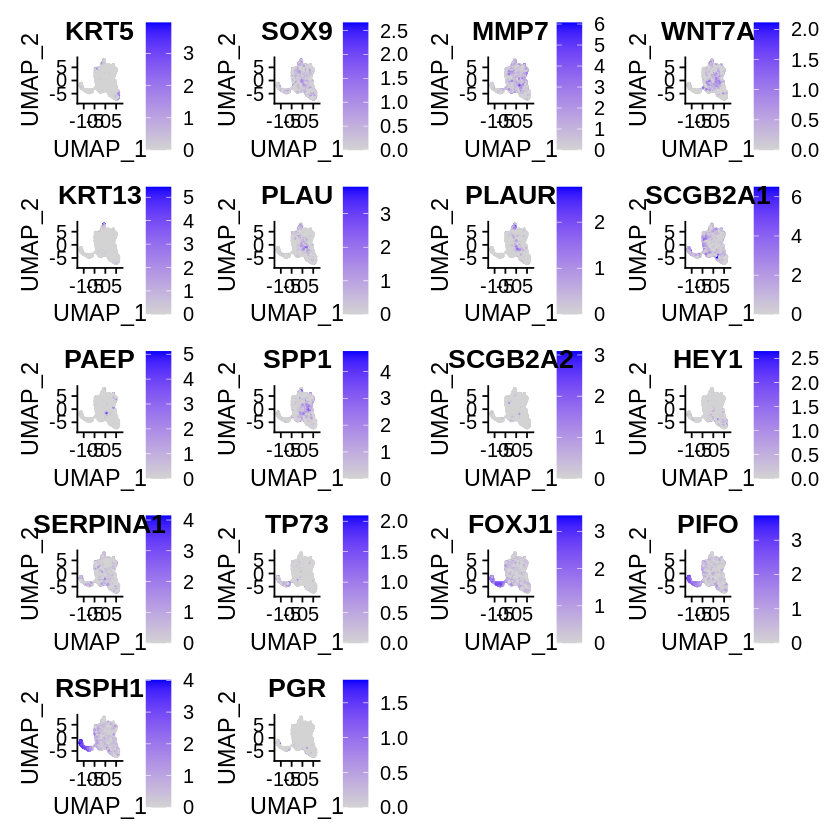

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: LGR6”


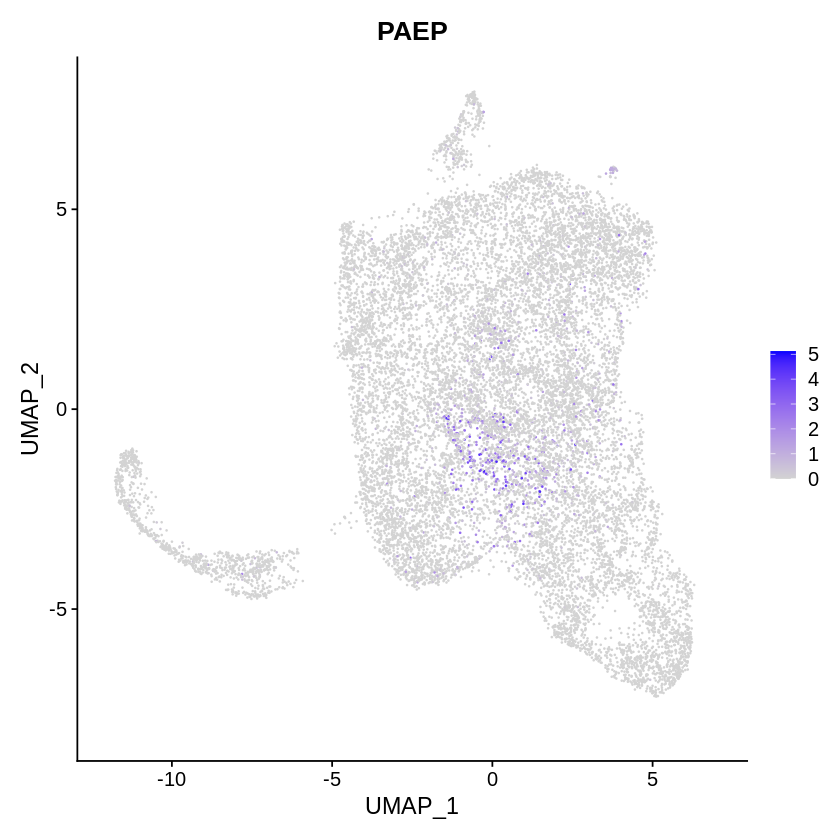

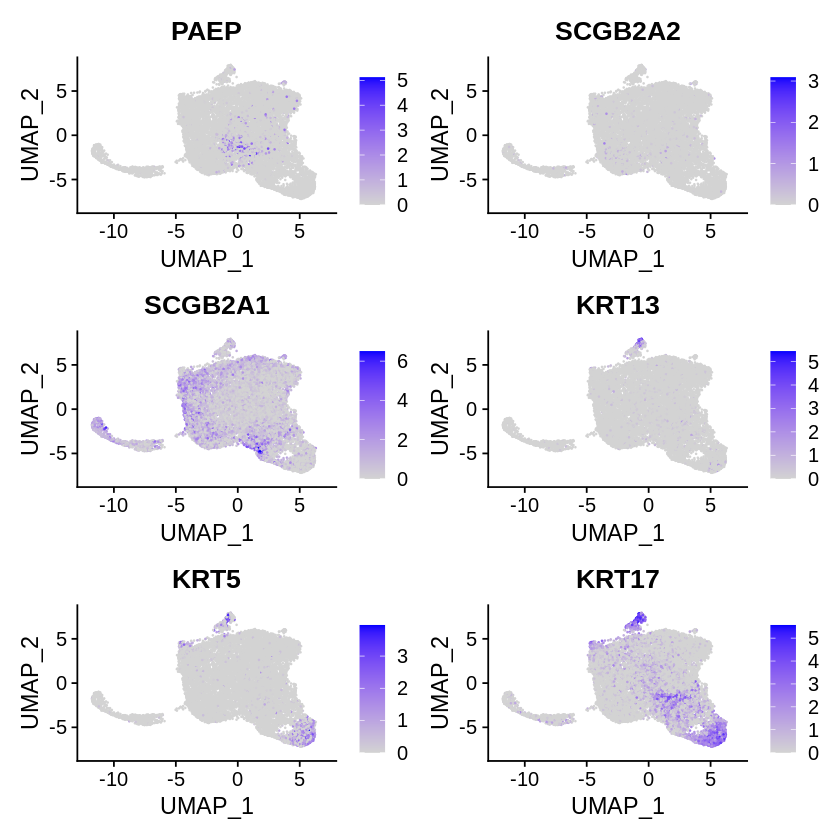

In [19]:
FeaturePlot(anndata, features = known_genes, ncol = 4)
ggsave(device = 'pdf', file = 'figures_organoid_confInhibitors/Donor44/seurat_umap_markerGenes.pdf', width = 15, height = 15)
FeaturePlot(anndata, features = 'PAEP')
FeaturePlot(anndata, features = c('PAEP','SCGB2A2','SCGB2A1','KRT13', 'KRT5', 'LGR6', 'KRT17'))

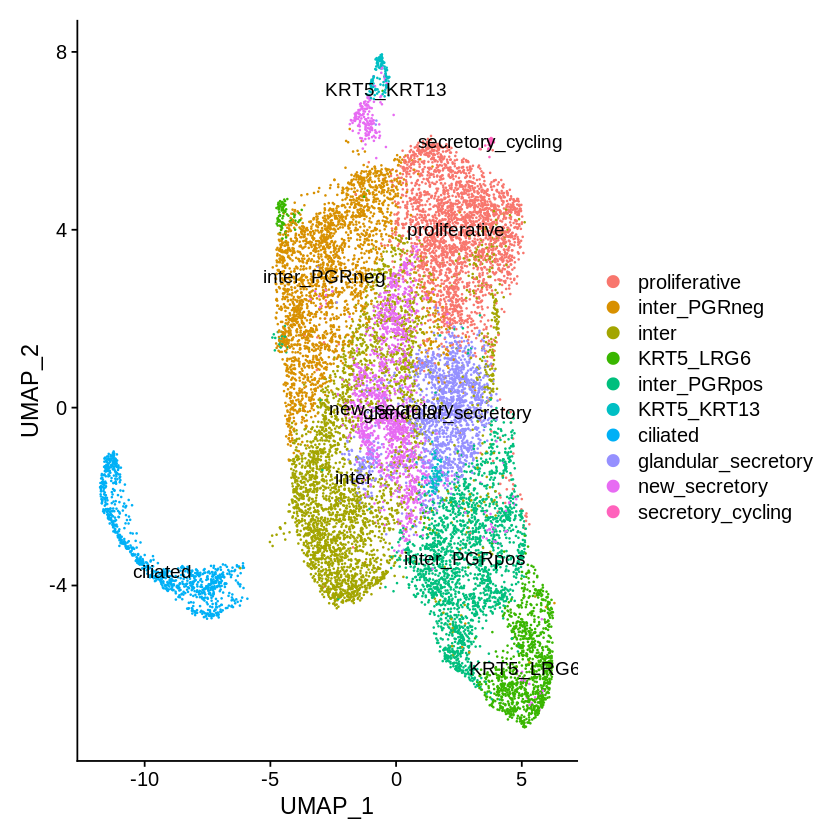

In [20]:
# Plot previous cluster
clustering = read.csv('figures_organoid_confInhibitors/Donor44/barcode_metadata.csv', stringsAsFactors = F)
rownames(clustering) = clustering$index
anndata@meta.data$clusters = clustering[rownames(anndata@meta.data), ]$clusters

# Assign identities and check
Idents(anndata) <- anndata@meta.data$clusters
DimPlot(anndata, reduction = "umap", label = T)

In [21]:
#save
saveRDS(anndata, file = '~/farm/endometrium/data/scATAC/organoidsI_Donor44_scRNA_seuratobject.rds')

In [22]:
markers = FindAllMarkers(anndata, test.use = 'LR')
write.csv(markers, file = 'figures_organoid_confInhibitors/Donor44/seurat_markers.csv')

Calculating cluster proliferative

Calculating cluster inter_PGRneg

Calculating cluster inter

Calculating cluster KRT5_LRG6

Calculating cluster inter_PGRpos

Calculating cluster KRT5_KRT13

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Calculating cluster ciliated

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Calculating cluster glandular_secretory

Calculating cluster new_secretory

Calculating cluster secretory_cycling

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilitie